In [17]:
!pip install emoji
!pip install plotly.io 
!pip install nbformat

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io


Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/7 [fastjsonschema]
   ---------------------------------------- 0/7 [fastjsonschema]
   ----------- ---------------------------- 2/7 [attrs]
   ----------- ---------------------------- 2/7 [attrs]
   ----------- ---------------------------- 2/7 [attrs]
   ----------------- ---------------------- 3/7 [referencing]
   ----------------- ---------------------- 3/7 [referencing]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   --------

In [39]:
import pandas as pd
import re

import regex
import demoji
import nbformat

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [40]:


# === 1. Funciones auxiliares ===
def inicia_con_fecha(linea):
    """Detecta si una línea empieza con fecha [dd/mm/aa, hh:mm]."""
    patron = r"^\[\d{2}/\d{2}/\d{2},\s\d{1,2}:\d{2}"
    return re.match(patron, linea) is not None

def obtener_partes(linea):
    """
    Separa cada línea en Fecha, Hora, Miembro y Mensaje.
    Formato esperado: [dd/mm/aa, hh:mm a.m./p.m.] Nombre: Mensaje
    """
    try:
        fecha_hora, resto = linea.split("] ", 1)
        fecha_hora = fecha_hora.strip("[]")
        fecha, hora = fecha_hora.split(", ")
        if ": " in resto:
            miembro, mensaje = resto.split(": ", 1)
        else:
            miembro, mensaje = "Sistema", resto
        return fecha, hora, miembro, mensaje
    except:
        return None, None, None, None

# === 2. Leer el archivo del chat ===
ruta_chat = "_chat.txt"
datos_lista = []

with open(ruta_chat, encoding="utf-8") as f:
    f.readline()  # salta la primera línea (cifrado extremo a extremo)
    for linea in f:
        linea = linea.strip()
        if inicia_con_fecha(linea):
            fecha, hora, miembro, mensaje = obtener_partes(linea)
            if fecha and hora:
                datos_lista.append([fecha, hora, miembro, mensaje])

# === 3. Convertir a DataFrame ===
df = pd.DataFrame(datos_lista, columns=["Fecha", "Hora", "Miembro", "Mensaje"])

# Normalizar formato de fecha
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%y", errors="coerce")

# Extra: columna de hora en formato datetime.time
df["Hora_dt"] = pd.to_datetime(df["Hora"], errors="coerce").dt.time

# Resetear índice
df = df.dropna(subset=["Fecha"]).reset_index(drop=True)

print("Primeras filas del chat limpio:")
display(df.head())
#print(df.info())

# === 4. Filtrar entre dos fechas ===
start_date = "2025-01-17"
end_date   = "2025-01-31"

df_filtrado = df[(df["Fecha"] >= start_date) & (df["Fecha"] <= end_date)].copy()

#print(f"\nMensajes entre {start_date} y {end_date}:")
#display(df_filtrado.head(20))

C:\Users\ajasa\AppData\Local\Temp\ipykernel_22988\2100977407.py:44: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Primeras filas del chat limpio:


,Fecha,Hora,Miembro,Mensaje,Hora_dt
0,2025-01-17,4:23:15 p.m.,Sam,"holaa, soy sam",16:23:15
1,2025-01-17,4:23:34 p.m.,Mike amors 💕,Holaa,16:23:34
2,2025-01-17,4:23:40 p.m.,Mike amors 💕,Voy a comer,16:23:40
3,2025-01-17,4:23:55 p.m.,Mike amors 💕,Me baño y ya voy para allá,16:23:55
4,2025-01-17,4:24:19 p.m.,Mike amors 💕,Puedo dejar la moto ahí contigo?,16:24:19


In [41]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if demoji.replace(caracter) != caracter:
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Media omitted>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'POLL:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,56531
Multimedia,0
Emojis,601
Links,132
Encuestas,0


In [42]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji').head(10)

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df

Número emojis únicos usados:  10 



,Cantidad
Emoji,
😔,137
😭,133
💀,83
😡,22
🤨,20
😈,20
💕,15
🤤,15
😍,14


In [43]:
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, hole=.3, template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20)
fig.update_layout(title={'text': 'Emojis que más usamos', 'y':0.96, 'x':0.5, 'xanchor': 'center'}, font=dict(size=17))
fig.show()

In [44]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos['% Mensaje'] = (df_MiembrosActivos['Mensaje'] / df_MiembrosActivos['Mensaje'].sum()) * 100
df_MiembrosActivos

,Miembro,Mensaje,% Mensaje
1,Sam,29723,52.578231
2,Mike amors 💕,26769,47.352780
3,Sistema,39,0.068989


In [45]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Media omitted>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Hora_dt,Emojis,URLs,Letras,Palabras
56526,2025-08-31,3:21:10 p.m.,Sam,cómo vasss,15:21:10,[],0,10,2
56527,2025-08-31,3:21:12 p.m.,Sam,te extraño,15:21:12,[],0,10,2
56528,2025-08-31,3:27:21 p.m.,Mike amors 💕,Menimos a la carniceria bb,15:27:21,[],0,26,5
56529,2025-08-31,3:28:02 p.m.,Sam,picioso,15:28:02,[],0,7,1
56530,2025-08-31,3:28:11 p.m.,Sam,salúdame a tu mami,15:28:11,[],0,18,4


In [46]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Sam': [29723, np.float64(3.385459072099048), 0, 177, 54], 'Mike amors 💕': [26769, np.float64(3.46501550300721), 0, 411, 78], 'Sistema': [39, np.float64(1.6666666666666667), 0, 13, 0]}


In [47]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df = miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Sam,29723,3.385459,0,177,54
Mike amors 💕,26769,3.465016,0,411,78
Sistema,39,1.666667,0,13,0


In [48]:
df['DiaSemana'] = df['Fecha'].dt.strftime('%A')
mapeo_dias_espanol = {'Monday': '1 Lunes','Tuesday': '2 Martes','Wednesday': '3 Miércoles','Thursday': '4 Jueves',
                      'Friday': '5 Viernes','Saturday': '6 Sábado','Sunday': '7 Domingo'}
df['DiaSemana'] = df['DiaSemana'].map(mapeo_dias_espanol)
df

,Fecha,Hora,Miembro,Mensaje,Hora_dt,Emojis,URLs,DiaSemana
0,2025-01-17,4:23:15 p.m.,Sam,"holaa, soy sam",16:23:15,[],0,5 Viernes
1,2025-01-17,4:23:34 p.m.,Mike amors 💕,Holaa,16:23:34,[],0,5 Viernes
2,2025-01-17,4:23:40 p.m.,Mike amors 💕,Voy a comer,16:23:40,[],0,5 Viernes
3,2025-01-17,4:23:55 p.m.,Mike amors 💕,Me baño y ya voy para allá,16:23:55,[],0,5 Viernes
4,2025-01-17,4:24:19 p.m.,Mike amors 💕,Puedo dejar la moto ahí contigo?,16:24:19,[],0,5 Viernes
...,...,...,...,...,...,...,...,...
56526,2025-08-31,3:21:10 p.m.,Sam,cómo vasss,15:21:10,[],0,7 Domingo
56527,2025-08-31,3:21:12 p.m.,Sam,te extraño,15:21:12,[],0,7 Domingo
56528,2025-08-31,3:27:21 p.m.,Mike amors 💕,Menimos a la carniceria bb,15:27:21,[],0,7 Domingo
56529,2025-08-31,3:28:02 p.m.,Sam,picioso,15:28:02,[],0,7 Domingo


In [49]:
import pandas as pd
import re

# 1. Limpiar la columna "Hora" (elimina segundos y normaliza am/pm)
def limpiar_hora(h):
    if pd.isna(h):
        return None
    h = str(h).lower().strip()
    # quitar segundos si existen, ej: 4:23:15 -> 4:23
    h = re.sub(r":\d{2}(?=\s*[ap]\.?m\.?)", "", h)
    # reemplazar "a.m." -> "AM", "p.m." -> "PM"
    h = h.replace("a. m.", "AM").replace("p. m.", "PM")
    h = h.replace("a.m.", "AM").replace("p.m.", "PM")
    return h

df["Hora_limpia"] = df["Hora"].apply(limpiar_hora)

# 2. Convertir a datetime (solo hora)
df["Hora_dt"] = pd.to_datetime(df["Hora_limpia"], format="%I:%M %p", errors="coerce")

# 3. Crear el rango de horas
def create_range_hour(hora):
    if pd.isna(hora):
        return None
    start_hour = hora.hour
    end_hour = (hora + pd.Timedelta(hours=1)).hour
    return f"{start_hour:02d} - {end_hour:02d} h"

df["rangoHora"] = df["Hora_dt"].apply(create_range_hour)

df[["Hora", "Hora_limpia", "Hora_dt", "rangoHora"]].head(10)


,Hora,Hora_limpia,Hora_dt,rangoHora
0,4:23:15 p.m.,4:23 PM,1900-01-01 16:23:00,16 - 17 h
1,4:23:34 p.m.,4:23 PM,1900-01-01 16:23:00,16 - 17 h
2,4:23:40 p.m.,4:23 PM,1900-01-01 16:23:00,16 - 17 h
3,4:23:55 p.m.,4:23 PM,1900-01-01 16:23:00,16 - 17 h
4,4:24:19 p.m.,4:24 PM,1900-01-01 16:24:00,16 - 17 h
5,4:24:24 p.m.,4:24 PM,1900-01-01 16:24:00,16 - 17 h
6,4:24:58 p.m.,4:24 PM,1900-01-01 16:24:00,16 - 17 h
7,4:25:06 p.m.,4:25 PM,1900-01-01 16:25:00,16 - 17 h
8,4:25:14 p.m.,4:25 PM,1900-01-01 16:25:00,16 - 17 h
9,4:25:20 p.m.,4:25 PM,1900-01-01 16:25:00,16 - 17 h


In [50]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('DiaSemana').count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='DiaSemana', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes contigo por día', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Día', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

In [51]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
mensajes_hora = df.groupby('rangoHora').count().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(mensajes_hora, x='rangoHora', y='# Mensajes por hora', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes contigo por hora', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

In [52]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes contigo a lo largo del tiempo', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

TypeError: datetime64 type does not support sum operations

In [53]:
# Asegura tipo fecha (sin hora)
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce').dt.date

# Conteo por día
date_df = df.groupby('Fecha').size().reset_index(name='# Mensajes por día')

# Graficar
import plotly.express as px
fig = px.line(date_df, x='Fecha', y='# Mensajes por día',
              template='plotly_dark', markers=True)
fig.show()


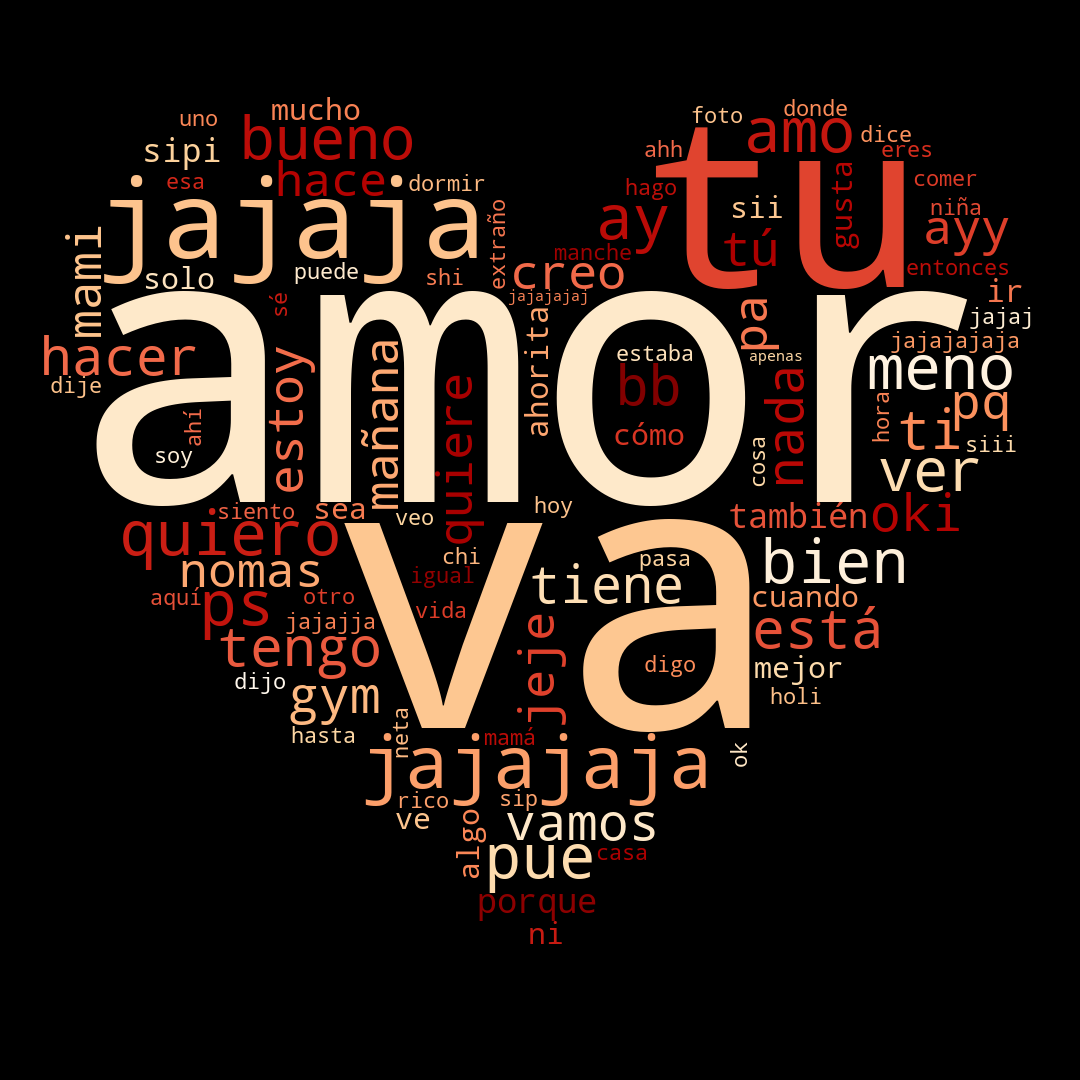

In [54]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Media','omitted',
                              'y', 'mi', 'o', 'q', 'yo', 'al', 'voy', 'p', 'jajajaj'])

mask = np.array(Image.open('heart.jpg'))

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=100, min_font_size = 5,
                      mask = mask, colormap='OrRd',).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()